# Implementation of German to English Translation Task from Attention is all you need paper

In [1]:
# !pip install torch torchtext spacy
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

In [ ]:

import warnings
import torchtext
torchtext.disable_torchtext_deprecation_warning()
warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import  DataLoader
from torchtext.datasets import Multi30k
from torch.nn.utils.rnn import pad_sequence
import spacy
from tqdm import tqdm
import math
from torchtext.data.metrics import bleu_score
from collections import Counter


def convert_ids_to_tokens(ids, vocab_dict):
    """Convert token ids back to text tokens"""
    # Create reverse vocabulary (id to token mapping)
    id_to_token = {v: k for k, v in vocab_dict.items()}
    return [id_to_token[id.item()] for id in ids]

def calculate_bleu(model, data_loader, dataset, device):
    ''' Calculate BLEU score on the validation set '''
    model.eval()
    all_candidates = []
    all_references = []
    
    with torch.no_grad():
        for src, tgt in data_loader:
            src = src.to(device)
            
            # Create masks for source
            src_padding_mask = (src != dataset.pad_idx).unsqueeze(1).unsqueeze(2)
            src_padding_mask = src_padding_mask.to(device)
            
            # Initialize target sequence with BOS token
            tgt_seq = torch.ones(src.size(0), 1, dtype=torch.long, device=device) * dataset.bos_idx
            
            # Generate translation one token at a time
            max_length = 50  # Maximum translation length
            
            for _ in range(max_length): # Limit prediction length
                tgt_padding_mask = (tgt_seq != dataset.pad_idx).unsqueeze(1).unsqueeze(2) # (batch_size, 1, 1, tgt_len)
                tgt_sub_mask = torch.triu(torch.ones((tgt_seq.size(1), tgt_seq.size(1))), diagonal=1).bool() # (tgt_len, tgt_len)
                
                tgt_padding_mask = tgt_padding_mask.to(device)
                tgt_sub_mask = tgt_sub_mask.to(device)
                # Forward pass
                output = model(
                    src,
                    tgt_seq,
                    src_padding_mask,
                    tgt_padding_mask,
                    tgt_sub_mask
                )
                
                # Get next token prediction
                next_token = output[:, -1, :].argmax(dim=1, keepdim=True)
                tgt_seq = torch.cat([tgt_seq, next_token], dim=1)
                
                # Stop if all sequences have generated EOS token
                if (next_token == dataset.eos_idx).all():
                    break
            
            # Convert ids back to tokens
            for pred_ids, true_ids in zip(tgt_seq, tgt):
                # Remove special tokens and get predicted tokens
                pred_tokens = convert_ids_to_tokens(
                    pred_ids[1:],  # Remove BOS token
                    dataset.tgt_vocab
                )
                # Stop at EOS token if present
                if dataset.eos_idx in pred_ids:
                    eos_idx = pred_ids.tolist().index(dataset.eos_idx)
                    pred_tokens = pred_tokens[:eos_idx]
                
                # Remove special tokens and get reference tokens
                true_tokens = convert_ids_to_tokens(
                    true_ids[1:-1],  # Remove BOS and EOS tokens
                    dataset.tgt_vocab
                )
                
                all_candidates.append(pred_tokens)
                all_references.append([true_tokens])  # BLEU expects list of lists for references
    
    # Calculate BLEU score
    bleu = bleu_score(all_candidates, all_references)
    return bleu

class PositionalEncoding(nn.Module):
    ''' Positional encoding for transformer '''
    def __init__(self, d_model, max_seq_length=100):
        super().__init__()
        pe = torch.zeros(max_seq_length, d_model) # (max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1) # (max_seq_length, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model/2)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe) 

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, dropout=0.1):
        ''' Multi-head attention module '''
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = math.sqrt(self.head_dim)
        
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        ''' Forward pass of multi-head attention '''
        batch_size = query.size(0)
        
        q = self.q_proj(query)
        k = self.k_proj(key)
        v = self.v_proj(value)
        
        q = q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2) # (batch_size, num_heads, seq_len, head_dim)
        k = k.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        # Compute scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        # Apply mask
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        # Compute attention weights
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        out = torch.matmul(attention_weights, v) # (batch_size, num_heads, seq_len, head_dim)
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        out = self.out_proj(out)
        
        return out, attention_weights

class TransformerEncoderLayer(nn.Module):
    ''' Single layer of transformer encoder '''
    def __init__(self, embed_dim=512, num_heads=8, ff_dim=2048, dropout=0.1):
        super().__init__()
        self.self_attn = MultiheadAttention(embed_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, _ = self.self_attn(x, x, x, mask) # (batch_size, seq_len, embed_dim)
        x = self.norm1(x + self.dropout(attn_output)) # Residual connection and layer normalization
        ff_output = self.feed_forward(x) # (batch_size, seq_len, embed_dim)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class TransformerDecoderLayer(nn.Module):
    ''' Single layer of transformer decoder '''
    def __init__(self, embed_dim=512, num_heads=8, ff_dim=2048, dropout=0.1):
        super().__init__()
        self.self_attn = MultiheadAttention(embed_dim, num_heads, dropout) # Self attention
        self.cross_attn = MultiheadAttention(embed_dim, num_heads, dropout) # Cross attention
        # Feed forward
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, tgt_padding_mask, tgt_sub_mask, src_padding_mask):
        # Self attention
        # Combine the padding mask and subsequent mask for self attention
        if tgt_padding_mask is not None and tgt_sub_mask is not None:
            tgt_mask = tgt_padding_mask & ~tgt_sub_mask
        else:
            tgt_mask = None
            
        # Self attention
        attn_output, _ = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Cross attention
        cross_attn_output, _ = self.cross_attn(x, enc_output, enc_output, src_padding_mask)
        x = self.norm2(x + self.dropout(cross_attn_output))
        
        # Feed forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        
        return x

class Transformer(nn.Module):
    ''' Transformer model '''
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim=512, num_heads=8,
                 num_encoder_layers=6, num_decoder_layers=6, ff_dim=2048, dropout=0.1):
        super().__init__()
        
        self.encoder_embedding = nn.Embedding(src_vocab_size, embed_dim, padding_idx=0) # Source embedding
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, embed_dim, padding_idx=0) # Target embedding
        self.positional_encoding = PositionalEncoding(embed_dim)
        # Transformer encoder
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_encoder_layers)
        ])
        # Transformer decoder
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_decoder_layers)
        ])
        
        self.output_layer = nn.Linear(embed_dim, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, tgt, src_padding_mask, tgt_padding_mask, tgt_sub_mask):
        # Embedding and positional encoding
        src_embed = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embed = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        
        # Encoder
        enc_output = src_embed
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_padding_mask)
        
        # Decoder
        dec_output = tgt_embed
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(
                dec_output,
                enc_output,
                tgt_padding_mask,
                tgt_sub_mask,
                src_padding_mask
            )
        
        output = self.output_layer(dec_output)
        return output

class TranslationDataset:
    ''' Multi30k Translation dataset '''
    def __init__(self, split='train', src_vocab=None, tgt_vocab=None):
        self.spacy_de = spacy.load('de_core_news_sm')
        self.spacy_en = spacy.load('en_core_web_sm')
        
        self.src_tokenizer = lambda text: [tok.text.lower() for tok in self.spacy_de.tokenizer(text)]
        self.tgt_tokenizer = lambda text: [tok.text.lower() for tok in self.spacy_en.tokenizer(text)]
        
        self.data = list(Multi30k(split=split, language_pair=('de', 'en')))
        
        # Define special tokens
        self.special_tokens = ['<unk>', '<pad>', '<bos>', '<eos>']
        
        # Use provided vocabularies for validation set
        if split != 'train' and src_vocab is not None and tgt_vocab is not None:
            self.src_vocab = src_vocab
            self.tgt_vocab = tgt_vocab
        else:
            # Build source vocabulary
            src_tokens = []
            for src_text, _ in self.data:
                src_tokens.extend(self.src_tokenizer(src_text))
            self.src_vocab = {token: idx + len(self.special_tokens) 
                             for idx, token in enumerate(sorted(set(src_tokens)))}
            # Add special tokens to source vocabulary
            for idx, token in enumerate(self.special_tokens):
                self.src_vocab[token] = idx
                
            # Build target vocabulary
            tgt_tokens = []
            for _, tgt_text in self.data:
                tgt_tokens.extend(self.tgt_tokenizer(tgt_text))
            self.tgt_vocab = {token: idx + len(self.special_tokens) 
                             for idx, token in enumerate(sorted(set(tgt_tokens)))}
            # Add special tokens to target vocabulary
            for idx, token in enumerate(self.special_tokens):
                self.tgt_vocab[token] = idx
        
        # Store special token indices
        self.pad_idx = self.src_vocab['<pad>']
        self.bos_idx = self.src_vocab['<bos>']
        self.eos_idx = self.src_vocab['<eos>']
        self.unk_idx = self.src_vocab['<unk>']
        
        self.src_vocab_size = len(self.src_vocab)
        self.tgt_vocab_size = len(self.tgt_vocab)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text, tgt_text = self.data[idx]
    
        # Tokenize and convert to indices, handling unknown tokens
        src_tokens = ['<bos>'] + self.src_tokenizer(src_text) + ['<eos>']
        tgt_tokens = ['<bos>'] + self.tgt_tokenizer(tgt_text) + ['<eos>']
    
        # Convert tokens to indices, using <unk> for unknown tokens
        src_ids = [self.src_vocab.get(token, self.unk_idx) for token in src_tokens]
        tgt_ids = [self.tgt_vocab.get(token, self.unk_idx) for token in tgt_tokens]
    
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def create_mask(src, tgt, pad_idx):
    ''' Create padding and subsequent masks '''
    # Source padding mask
    src_padding_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, src_len)
    
    # Target padding mask
    tgt_padding_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, tgt_len)
    
    # Target subsequent mask (causal mask)
    tgt_len = tgt.size(1)
    tgt_sub_mask = torch.triu(torch.ones((tgt_len, tgt_len)), diagonal=1).bool()
    tgt_sub_mask = tgt_sub_mask.to(tgt.device)
    
    return src_padding_mask, tgt_padding_mask, tgt_sub_mask

def collate_fn(batch):
    ''' Pad sequences in batch to same length '''
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch: # Tuple of (src, tgt)
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)
    
    # Pad sequences in batch to same length
    src_batch = pad_sequence(src_batch, padding_value=0, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=0, batch_first=True)
    
    return src_batch, tgt_batch

class LabelSmoothingLoss(nn.Module):
    ''' Label smoothing loss '''
    def __init__(self, smoothing=0.1, ignore_index=None):
        super().__init__()
        self.smoothing = smoothing # Smoothing factor
        self.ignore_index = ignore_index # Index to ignore in loss calculation
        self.confidence = 1.0 - smoothing   # Confidence in true labels
        
    def forward(self, pred, target):
        """
        pred (batch_size * seq_len, vocab_size)
        target (batch_size * seq_len)
        """
        if self.ignore_index is not None:
            # Create mask for ignored indices (like padding)
            non_pad_mask = (target != self.ignore_index)
            target = target[non_pad_mask]
            pred = pred[non_pad_mask]
            
            if len(target) == 0:  # All padding
                return torch.tensor(0.0, device=pred.device)
        
        vocab_size = pred.size(-1) # Number of classes
        
        # KL divergence between pred and smoothed target
        with torch.no_grad():
            # Create smoothed target distribution
            true_dist = torch.zeros_like(pred) # (batch_size * seq_len, vocab_size)
            true_dist.fill_(self.smoothing / (vocab_size - 1)) # Fill with smoothing factor
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence) # Fill true values with confidence
        # Compute KL divergence
        kl_div = F.kl_div(
            F.log_softmax(pred, dim=-1),
            true_dist,
            reduction='sum'
        )
        
        return kl_div / target.size(0)  # Normalize by batch size
    
def train_model(model, train_loader, optimizer, criterion, device, pad_idx):
    ''' Train the model for one epoch '''
    model.train()
    total_loss = 0
    
    for batch_idx, (src, tgt) in enumerate(tqdm(train_loader)):
        src, tgt = src.to(device), tgt.to(device)
        
        # Create masks
        src_padding_mask, tgt_padding_mask, tgt_sub_mask = create_mask(src, tgt[:, :-1], pad_idx)
        src_padding_mask = src_padding_mask.to(device)
        tgt_padding_mask = tgt_padding_mask.to(device)
        tgt_sub_mask = tgt_sub_mask.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output = model(
            src,
            tgt[:, :-1],
            src_padding_mask,
            tgt_padding_mask,
            tgt_sub_mask
        )
        
        # Calculate loss with label smoothing
        loss = criterion(
            output.contiguous().view(-1, output.size(-1)),
            tgt[:, 1:].contiguous().view(-1)
        )
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')
    
    return total_loss / len(train_loader)

def evaluate_model(model, val_loader, criterion, device, pad_idx,dataset):
    ''' Evaluate the model on the validation set '''
    model.eval()
    total_loss = 0
    
    with torch.no_grad(): # Disable gradient tracking
        for src, tgt in tqdm(val_loader, desc='Evaluation'): # Validation loop
            src, tgt = src.to(device), tgt.to(device)
            
            src_padding_mask, tgt_padding_mask, tgt_sub_mask = create_mask(src, tgt[:, :-1], pad_idx) # Create masks
            src_padding_mask = src_padding_mask.to(device)
            tgt_padding_mask = tgt_padding_mask.to(device)
            tgt_sub_mask = tgt_sub_mask.to(device)
            output = model(
                src,
                tgt[:, :-1],
                src_padding_mask,
                tgt_padding_mask,
                tgt_sub_mask
            )

            loss = criterion(
                output.contiguous().view(-1, output.size(-1)),
                tgt[:, 1:].contiguous().view(-1)
            )
            total_loss += loss.item()
    val_loss = total_loss / len(val_loader)
    return  val_loss, None

def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, scheduler, 
                      device, train_dataset, num_epochs=10):
    ''' Train and evaluate the model called to perform the above functions at once'''
    best_val_loss = float('inf')
    best_bleu = 0.0
    
    for epoch in range(num_epochs): # Epoch loop
        # Training phase
        train_loss = train_model(model, train_loader, optimizer, criterion, device, train_dataset.pad_idx)
        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}')
        
        # Validation phase
        val_loss, bleu = evaluate_model(model, val_loader, criterion, device, train_dataset.pad_idx,train_dataset)
        print(f'Validation Loss: {val_loss:.4f}')
        
        # Calculate BLEU score
        bleu = calculate_bleu(model, val_loader, train_dataset, device)
        print(f'BLEU Score: {bleu:.4f}')
        
        # Update learning rate
        scheduler.step()
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_bleu = bleu
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'bleu': bleu
            }, 'best_model.pt')
            
        print(f'Best Validation Loss: {best_val_loss:.4f}, Best BLEU Score: {best_bleu:.4f}\n')


# Usage example
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create datasets
    train_dataset = TranslationDataset(split='train')
    # Create validation dataset with training vocabulary
    val_dataset = TranslationDataset(
        split='valid',
        src_vocab=train_dataset.src_vocab,
        tgt_vocab=train_dataset.tgt_vocab
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        collate_fn=collate_fn
    )
    print('Building model')
    # Initialize model
    model = Transformer(
        src_vocab_size=len(train_dataset.src_vocab),
        tgt_vocab_size=len(train_dataset.tgt_vocab),
        embed_dim=512,
        num_heads=1,
        num_encoder_layers=2,
        num_decoder_layers=2
    ).to(device)

     # Training setup
    criterion = LabelSmoothingLoss(smoothing=0.1, ignore_index=train_dataset.pad_idx)
    d_model = 512  # embedding dimension
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98))
    
    # Learning rate scheduler with warmup
    class WarmupScheduler:
        ''' Learning rate scheduler with warmup '''
        def __init__(self, optimizer, d_model, warmup_steps=4000):
            self.optimizer = optimizer
            self.d_model = d_model
            self.warmup_steps = warmup_steps
            self.current_step = 0
            
        def step(self):
            ''' Update learning rate and increment step '''
            self.current_step += 1
            lr = self.get_lr()
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        
        def get_lr(self):
            step = self.current_step
            return self.d_model ** (-0.5) * min(step ** (-0.5), step * self.warmup_steps ** (-1.5))
    
    scheduler = WarmupScheduler(optimizer, d_model)

    print('Training model')
    train_and_evaluate(
        model, 
        train_loader, 
        val_loader, 
        optimizer, 
        criterion, 
        scheduler,
        device, 
        train_dataset,
        num_epochs=20
    )

/var/folders/rv/fj66wyxd1tzgh8y6tktcmty40000gn/T/ipykernel_84426/4216180982.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


Building model
Training model


  0%|          | 1/907 [00:00<11:46,  1.28it/s]

Batch 0, Loss: 7.8814


 11%|█         | 101/907 [01:05<07:39,  1.75it/s]

Batch 100, Loss: 2.8866


 22%|██▏       | 201/907 [02:09<06:47,  1.73it/s]

Batch 200, Loss: 2.2941


 33%|███▎      | 301/907 [03:07<05:26,  1.86it/s]

Batch 300, Loss: 1.9137


 44%|████▍     | 401/907 [04:13<04:46,  1.77it/s]

Batch 400, Loss: 1.6076


 55%|█████▌    | 501/907 [05:14<03:55,  1.73it/s]

Batch 500, Loss: 1.7115


 66%|██████▋   | 601/907 [06:18<03:15,  1.56it/s]

Batch 600, Loss: 1.8014


 77%|███████▋  | 701/907 [07:22<02:15,  1.52it/s]

Batch 700, Loss: 1.4891


 88%|████████▊ | 801/907 [08:20<00:57,  1.84it/s]

Batch 800, Loss: 1.5054


 99%|█████████▉| 901/907 [09:20<00:03,  1.67it/s]

Batch 900, Loss: 2.1690


100%|██████████| 907/907 [09:23<00:00,  1.61it/s]


Epoch: 1, Train Loss: 1.9606


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


Validation Loss: 1.5174
BLEU Score: 0.0931
Best Validation Loss: 1.5174, Best BLEU Score: 0.0931



  0%|          | 1/907 [00:00<08:39,  1.74it/s]

Batch 0, Loss: 1.9306


 11%|█         | 101/907 [01:01<09:15,  1.45it/s]

Batch 100, Loss: 1.7882


 22%|██▏       | 201/907 [02:02<06:47,  1.73it/s]

Batch 200, Loss: 1.6603


 33%|███▎      | 301/907 [03:01<05:23,  1.87it/s]

Batch 300, Loss: 1.6368


 44%|████▍     | 401/907 [03:58<05:51,  1.44it/s]

Batch 400, Loss: 0.9690


 55%|█████▌    | 501/907 [04:55<03:48,  1.78it/s]

Batch 500, Loss: 1.3225


 66%|██████▋   | 601/907 [05:52<03:08,  1.62it/s]

Batch 600, Loss: 1.4841


 77%|███████▋  | 701/907 [17:50<5:36:20, 97.96s/it]  

Batch 700, Loss: 1.3736


 88%|████████▊ | 801/907 [18:53<01:00,  1.75it/s]  

Batch 800, Loss: 1.3700


 99%|█████████▉| 901/907 [19:53<00:03,  1.53it/s]

Batch 900, Loss: 1.6893


100%|██████████| 907/907 [19:56<00:00,  1.32s/it]


Epoch: 2, Train Loss: 1.5549


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


Validation Loss: 1.5080
BLEU Score: 0.0977
Best Validation Loss: 1.5080, Best BLEU Score: 0.0977



  0%|          | 1/907 [00:00<14:42,  1.03it/s]

Batch 0, Loss: 1.2547


 11%|█         | 101/907 [01:03<08:12,  1.64it/s]

Batch 100, Loss: 1.4959


 22%|██▏       | 201/907 [02:07<07:16,  1.62it/s]

Batch 200, Loss: 1.5129


 33%|███▎      | 301/907 [03:12<05:55,  1.70it/s]

Batch 300, Loss: 1.6984


 44%|████▍     | 401/907 [04:12<04:52,  1.73it/s]

Batch 400, Loss: 1.4501


 55%|█████▌    | 501/907 [05:11<04:16,  1.58it/s]

Batch 500, Loss: 1.3150


 66%|██████▋   | 601/907 [06:10<02:51,  1.79it/s]

Batch 600, Loss: 1.3744


 77%|███████▋  | 701/907 [07:10<02:09,  1.59it/s]

Batch 700, Loss: 1.5563


 88%|████████▊ | 801/907 [08:09<01:07,  1.56it/s]

Batch 800, Loss: 1.7172


 99%|█████████▉| 901/907 [09:11<00:03,  1.82it/s]

Batch 900, Loss: 1.7579


100%|██████████| 907/907 [09:14<00:00,  1.63it/s]


Epoch: 3, Train Loss: 1.5479


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.35it/s]


Validation Loss: 1.5013
BLEU Score: 0.0977
Best Validation Loss: 1.5013, Best BLEU Score: 0.0977



  0%|          | 1/907 [00:00<10:00,  1.51it/s]

Batch 0, Loss: 1.2286


 11%|█         | 101/907 [10:01<08:11,  1.64it/s]  

Batch 100, Loss: 1.6488


 22%|██▏       | 201/907 [11:10<09:05,  1.29it/s]

Batch 200, Loss: 1.1292


 33%|███▎      | 301/907 [12:08<05:20,  1.89it/s]

Batch 300, Loss: 1.8862


 44%|████▍     | 401/907 [13:11<05:22,  1.57it/s]

Batch 400, Loss: 1.3469


 55%|█████▌    | 501/907 [14:14<04:29,  1.50it/s]

Batch 500, Loss: 1.5848


 66%|██████▋   | 601/907 [18:51<04:17,  1.19it/s]  

Batch 600, Loss: 1.7509


 77%|███████▋  | 701/907 [19:59<02:05,  1.65it/s]

Batch 700, Loss: 1.5266


 88%|████████▊ | 801/907 [21:19<01:25,  1.24it/s]

Batch 800, Loss: 1.5065


 99%|█████████▉| 901/907 [22:44<00:03,  1.66it/s]

Batch 900, Loss: 1.6765


100%|██████████| 907/907 [22:48<00:00,  1.51s/it]


Epoch: 4, Train Loss: 1.5400


Evaluation: 100%|██████████| 32/32 [00:06<00:00,  5.06it/s]


Validation Loss: 1.4965
BLEU Score: 0.0987
Best Validation Loss: 1.4965, Best BLEU Score: 0.0987



  0%|          | 1/907 [00:00<09:40,  1.56it/s]

Batch 0, Loss: 1.9325


 11%|█         | 101/907 [01:13<10:07,  1.33it/s]

Batch 100, Loss: 1.5213


 22%|██▏       | 201/907 [02:33<10:33,  1.11it/s]

Batch 200, Loss: 1.6432


 33%|███▎      | 301/907 [04:13<11:37,  1.15s/it]

Batch 300, Loss: 1.4755


 44%|████▍     | 401/907 [06:09<09:46,  1.16s/it]

Batch 400, Loss: 1.2124


 55%|█████▌    | 501/907 [07:58<05:01,  1.35it/s]

Batch 500, Loss: 1.7806


 66%|██████▋   | 601/907 [09:25<04:59,  1.02it/s]

Batch 600, Loss: 1.6756


 77%|███████▋  | 701/907 [10:55<02:40,  1.28it/s]

Batch 700, Loss: 1.7039


 88%|████████▊ | 801/907 [12:24<01:47,  1.01s/it]

Batch 800, Loss: 1.4277


 99%|█████████▉| 901/907 [13:57<00:05,  1.06it/s]

Batch 900, Loss: 1.5545


100%|██████████| 907/907 [14:01<00:00,  1.08it/s]


Epoch: 5, Train Loss: 1.5343


Evaluation: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Validation Loss: 1.4910
BLEU Score: 0.1005
Best Validation Loss: 1.4910, Best BLEU Score: 0.1005



  0%|          | 1/907 [00:00<12:22,  1.22it/s]

Batch 0, Loss: 1.8791


 11%|█         | 101/907 [01:37<14:16,  1.06s/it]

Batch 100, Loss: 1.3101


 22%|██▏       | 201/907 [03:12<10:38,  1.11it/s]

Batch 200, Loss: 1.5564


 33%|███▎      | 301/907 [04:40<08:40,  1.16it/s]

Batch 300, Loss: 1.5162


 44%|████▍     | 401/907 [06:03<06:52,  1.23it/s]

Batch 400, Loss: 1.4008


 55%|█████▌    | 501/907 [07:33<06:19,  1.07it/s]

Batch 500, Loss: 1.7488


 66%|██████▋   | 601/907 [08:57<04:15,  1.20it/s]

Batch 600, Loss: 1.3456


 77%|███████▋  | 701/907 [10:23<02:52,  1.20it/s]

Batch 700, Loss: 1.7707


 88%|████████▊ | 801/907 [11:52<01:38,  1.08it/s]

Batch 800, Loss: 1.8464


 99%|█████████▉| 901/907 [13:19<00:04,  1.24it/s]

Batch 900, Loss: 1.8754


100%|██████████| 907/907 [13:24<00:00,  1.13it/s]


Epoch: 6, Train Loss: 1.5314


Evaluation: 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


Validation Loss: 1.4860
BLEU Score: 0.0993
Best Validation Loss: 1.4860, Best BLEU Score: 0.0993



  0%|          | 1/907 [00:00<12:35,  1.20it/s]

Batch 0, Loss: 1.2825


 11%|█         | 101/907 [01:27<12:57,  1.04it/s]

Batch 100, Loss: 1.7907


 22%|██▏       | 201/907 [03:23<12:52,  1.09s/it]

Batch 200, Loss: 1.4595


 33%|███▎      | 301/907 [04:54<08:16,  1.22it/s]

Batch 300, Loss: 1.4724


 44%|████▍     | 401/907 [06:16<06:03,  1.39it/s]

Batch 400, Loss: 1.9371


 55%|█████▌    | 501/907 [07:32<05:10,  1.31it/s]

Batch 500, Loss: 1.7917


 66%|██████▋   | 601/907 [08:48<03:56,  1.30it/s]

Batch 600, Loss: 1.7342


 77%|███████▋  | 701/907 [10:04<02:34,  1.33it/s]

Batch 700, Loss: 1.5315


 88%|████████▊ | 801/907 [11:21<01:29,  1.18it/s]

Batch 800, Loss: 1.0128


 99%|█████████▉| 901/907 [12:37<00:04,  1.21it/s]

Batch 900, Loss: 1.3270


100%|██████████| 907/907 [12:40<00:00,  1.19it/s]


Epoch: 7, Train Loss: 1.5251


Evaluation: 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]


Validation Loss: 1.4811
BLEU Score: 0.1003
Best Validation Loss: 1.4811, Best BLEU Score: 0.1003



  0%|          | 1/907 [00:00<13:42,  1.10it/s]

Batch 0, Loss: 1.2101


 11%|█         | 101/907 [01:21<11:28,  1.17it/s]

Batch 100, Loss: 1.7759


 22%|██▏       | 201/907 [02:45<08:59,  1.31it/s]

Batch 200, Loss: 1.4126


 33%|███▎      | 301/907 [04:03<08:11,  1.23it/s]

Batch 300, Loss: 1.1503


 44%|████▍     | 401/907 [05:20<06:46,  1.24it/s]

Batch 400, Loss: 1.6379


 55%|█████▌    | 501/907 [06:36<05:36,  1.21it/s]

Batch 500, Loss: 1.5074


 66%|██████▋   | 601/907 [07:49<03:35,  1.42it/s]

Batch 600, Loss: 1.2584


 77%|███████▋  | 701/907 [09:04<02:24,  1.43it/s]

Batch 700, Loss: 1.7834


 88%|████████▊ | 801/907 [10:16<01:11,  1.48it/s]

Batch 800, Loss: 1.9160


 99%|█████████▉| 901/907 [11:31<00:04,  1.38it/s]

Batch 900, Loss: 1.6756


100%|██████████| 907/907 [11:35<00:00,  1.30it/s]


Epoch: 8, Train Loss: 1.5163


Evaluation: 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


Validation Loss: 1.4751
BLEU Score: 0.1013
Best Validation Loss: 1.4751, Best BLEU Score: 0.1013



  0%|          | 1/907 [00:00<13:51,  1.09it/s]

Batch 0, Loss: 1.1070


 11%|█         | 101/907 [01:06<08:20,  1.61it/s]

Batch 100, Loss: 1.5677


 22%|██▏       | 201/907 [02:08<07:29,  1.57it/s]

Batch 200, Loss: 1.3492


 33%|███▎      | 301/907 [03:11<06:26,  1.57it/s]

Batch 300, Loss: 1.4889


 44%|████▍     | 401/907 [04:12<04:48,  1.75it/s]

Batch 400, Loss: 1.3712


 55%|█████▌    | 501/907 [05:09<04:07,  1.64it/s]

Batch 500, Loss: 1.1194


 66%|██████▋   | 601/907 [06:14<02:59,  1.70it/s]

Batch 600, Loss: 1.3270


 77%|███████▋  | 701/907 [07:13<01:55,  1.78it/s]

Batch 700, Loss: 1.4504


 88%|████████▊ | 801/907 [08:13<00:57,  1.84it/s]

Batch 800, Loss: 1.5749


 99%|█████████▉| 901/907 [09:13<00:03,  1.88it/s]

Batch 900, Loss: 1.5909


100%|██████████| 907/907 [09:17<00:00,  1.63it/s]


Epoch: 9, Train Loss: 1.5208


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


Validation Loss: 1.4697
BLEU Score: 0.1023
Best Validation Loss: 1.4697, Best BLEU Score: 0.1023



  0%|          | 1/907 [00:00<09:22,  1.61it/s]

Batch 0, Loss: 1.5204


 11%|█         | 101/907 [01:05<08:03,  1.67it/s]

Batch 100, Loss: 1.2692


 22%|██▏       | 201/907 [02:09<07:24,  1.59it/s]

Batch 200, Loss: 1.2551


 33%|███▎      | 301/907 [03:13<06:14,  1.62it/s]

Batch 300, Loss: 1.6617


 44%|████▍     | 401/907 [04:14<04:53,  1.73it/s]

Batch 400, Loss: 1.7563


 55%|█████▌    | 501/907 [05:13<04:10,  1.62it/s]

Batch 500, Loss: 1.5134


 66%|██████▋   | 601/907 [06:11<03:03,  1.67it/s]

Batch 600, Loss: 1.7329


 77%|███████▋  | 701/907 [07:10<01:52,  1.82it/s]

Batch 700, Loss: 1.5557


 88%|████████▊ | 801/907 [08:09<01:00,  1.74it/s]

Batch 800, Loss: 1.2158


 99%|█████████▉| 901/907 [09:10<00:03,  1.57it/s]

Batch 900, Loss: 1.5476


100%|██████████| 907/907 [09:13<00:00,  1.64it/s]


Epoch: 10, Train Loss: 1.5125


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


Validation Loss: 1.4643
BLEU Score: 0.1029
Best Validation Loss: 1.4643, Best BLEU Score: 0.1029



  0%|          | 1/907 [00:00<10:55,  1.38it/s]

Batch 0, Loss: 1.5573


 11%|█         | 101/907 [01:03<08:11,  1.64it/s]

Batch 100, Loss: 1.7253


 22%|██▏       | 201/907 [02:07<06:51,  1.71it/s]

Batch 200, Loss: 1.8455


 33%|███▎      | 301/907 [03:13<05:58,  1.69it/s]

Batch 300, Loss: 1.6091


 44%|████▍     | 401/907 [04:14<04:34,  1.84it/s]

Batch 400, Loss: 1.7443


 55%|█████▌    | 501/907 [05:12<03:58,  1.70it/s]

Batch 500, Loss: 1.5571


 66%|██████▋   | 601/907 [06:10<02:53,  1.77it/s]

Batch 600, Loss: 1.5754


 77%|███████▋  | 701/907 [07:10<02:16,  1.51it/s]

Batch 700, Loss: 0.9255


 88%|████████▊ | 801/907 [08:11<00:57,  1.84it/s]

Batch 800, Loss: 1.4790


 99%|█████████▉| 901/907 [09:11<00:03,  1.67it/s]

Batch 900, Loss: 1.6061


100%|██████████| 907/907 [09:15<00:00,  1.63it/s]


Epoch: 11, Train Loss: 1.5042


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.89it/s]


Validation Loss: 1.4576
BLEU Score: 0.1037
Best Validation Loss: 1.4576, Best BLEU Score: 0.1037



  0%|          | 1/907 [00:00<09:38,  1.57it/s]

Batch 0, Loss: 1.7401


 11%|█         | 101/907 [01:04<10:00,  1.34it/s]

Batch 100, Loss: 1.1896


 22%|██▏       | 201/907 [02:17<06:35,  1.78it/s]

Batch 200, Loss: 1.5250


 33%|███▎      | 301/907 [03:16<05:58,  1.69it/s]

Batch 300, Loss: 1.2016


 44%|████▍     | 401/907 [04:20<06:21,  1.33it/s]

Batch 400, Loss: 1.1837


 55%|█████▌    | 501/907 [05:49<04:39,  1.45it/s]

Batch 500, Loss: 1.5768


 66%|██████▋   | 601/907 [06:56<03:06,  1.64it/s]

Batch 600, Loss: 1.5048


 77%|███████▋  | 701/907 [08:00<02:12,  1.55it/s]

Batch 700, Loss: 1.3378


 88%|████████▊ | 801/907 [09:03<01:04,  1.64it/s]

Batch 800, Loss: 1.7006


 99%|█████████▉| 901/907 [10:09<00:04,  1.33it/s]

Batch 900, Loss: 1.6724


100%|██████████| 907/907 [10:12<00:00,  1.48it/s]


Epoch: 12, Train Loss: 1.4982


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.74it/s]


Validation Loss: 1.4517
BLEU Score: 0.1052
Best Validation Loss: 1.4517, Best BLEU Score: 0.1052



  0%|          | 1/907 [00:00<09:42,  1.56it/s]

Batch 0, Loss: 1.5314


 11%|█         | 101/907 [01:08<08:27,  1.59it/s]

Batch 100, Loss: 1.5740


 22%|██▏       | 201/907 [02:20<10:13,  1.15it/s]

Batch 200, Loss: 1.3942


 33%|███▎      | 301/907 [03:28<06:38,  1.52it/s]

Batch 300, Loss: 1.2084


 44%|████▍     | 401/907 [04:31<05:13,  1.61it/s]

Batch 400, Loss: 1.5176


 55%|█████▌    | 501/907 [05:39<04:08,  1.64it/s]

Batch 500, Loss: 1.6108


 66%|██████▋   | 601/907 [06:45<02:58,  1.72it/s]

Batch 600, Loss: 1.4560


 77%|███████▋  | 701/907 [08:35<02:21,  1.46it/s]  

Batch 700, Loss: 1.6911


 88%|████████▊ | 801/907 [09:36<00:56,  1.88it/s]

Batch 800, Loss: 1.7494


 99%|█████████▉| 901/907 [26:06<00:03,  1.73it/s]   

Batch 900, Loss: 1.6552


100%|██████████| 907/907 [26:09<00:00,  1.73s/it]


Epoch: 13, Train Loss: 1.4918


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.02it/s]


Validation Loss: 1.4448
BLEU Score: 0.1056
Best Validation Loss: 1.4448, Best BLEU Score: 0.1056



  0%|          | 1/907 [00:00<13:19,  1.13it/s]

Batch 0, Loss: 1.6021


 11%|█         | 101/907 [01:14<09:35,  1.40it/s]

Batch 100, Loss: 1.8006


 22%|██▏       | 201/907 [02:40<09:48,  1.20it/s]

Batch 200, Loss: 1.7335


 33%|███▎      | 301/907 [04:14<11:08,  1.10s/it]

Batch 300, Loss: 1.5942


 44%|████▍     | 401/907 [05:49<06:22,  1.32it/s]

Batch 400, Loss: 1.8464


 55%|█████▌    | 501/907 [07:08<05:12,  1.30it/s]

Batch 500, Loss: 1.4326


 66%|██████▋   | 601/907 [08:26<04:20,  1.18it/s]

Batch 600, Loss: 1.2828


 77%|███████▋  | 701/907 [09:50<02:43,  1.26it/s]

Batch 700, Loss: 1.7566


 88%|████████▊ | 801/907 [11:10<01:27,  1.21it/s]

Batch 800, Loss: 1.3804


 99%|█████████▉| 901/907 [12:30<00:04,  1.24it/s]

Batch 900, Loss: 1.5806


100%|██████████| 907/907 [12:34<00:00,  1.20it/s]


Epoch: 14, Train Loss: 1.4847


Evaluation: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


Validation Loss: 1.4364
BLEU Score: 0.1070
Best Validation Loss: 1.4364, Best BLEU Score: 0.1070



  0%|          | 1/907 [00:00<15:05,  1.00it/s]

Batch 0, Loss: 1.1305


 11%|█         | 101/907 [01:30<12:25,  1.08it/s]

Batch 100, Loss: 1.3466


 22%|██▏       | 201/907 [03:15<12:06,  1.03s/it]

Batch 200, Loss: 1.1916


 33%|███▎      | 301/907 [04:50<07:58,  1.27it/s]

Batch 300, Loss: 1.7541


 44%|████▍     | 401/907 [06:16<07:02,  1.20it/s]

Batch 400, Loss: 1.3375


 55%|█████▌    | 501/907 [07:38<05:26,  1.24it/s]

Batch 500, Loss: 1.5011


 66%|██████▋   | 601/907 [09:01<04:17,  1.19it/s]

Batch 600, Loss: 1.4123


 77%|███████▋  | 701/907 [10:32<03:12,  1.07it/s]

Batch 700, Loss: 1.3755


 88%|████████▊ | 801/907 [12:04<01:44,  1.02it/s]

Batch 800, Loss: 1.7039


 99%|█████████▉| 901/907 [13:29<00:05,  1.13it/s]

Batch 900, Loss: 1.2571


100%|██████████| 907/907 [13:33<00:00,  1.11it/s]


Epoch: 15, Train Loss: 1.4710


Evaluation: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Validation Loss: 1.4297
BLEU Score: 0.1085
Best Validation Loss: 1.4297, Best BLEU Score: 0.1085



  0%|          | 1/907 [00:00<11:09,  1.35it/s]

Batch 0, Loss: 1.5367


 11%|█         | 101/907 [01:29<12:08,  1.11it/s]

Batch 100, Loss: 1.4211


 22%|██▏       | 201/907 [02:50<06:18,  1.87it/s]

Batch 200, Loss: 1.8671


 33%|███▎      | 301/907 [03:46<05:44,  1.76it/s]

Batch 300, Loss: 1.7707


 44%|████▍     | 401/907 [04:43<04:27,  1.89it/s]

Batch 400, Loss: 1.6838


 55%|█████▌    | 501/907 [05:40<03:53,  1.74it/s]

Batch 500, Loss: 1.3062


 66%|██████▋   | 601/907 [06:37<02:59,  1.70it/s]

Batch 600, Loss: 1.2653


 77%|███████▋  | 701/907 [07:33<01:45,  1.96it/s]

Batch 700, Loss: 1.4127


 88%|████████▊ | 801/907 [08:29<00:59,  1.78it/s]

Batch 800, Loss: 1.5753


 99%|█████████▉| 901/907 [09:24<00:03,  1.78it/s]

Batch 900, Loss: 1.2665


100%|██████████| 907/907 [09:27<00:00,  1.60it/s]


Epoch: 16, Train Loss: 1.4654


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


Validation Loss: 1.4220
BLEU Score: 0.1084
Best Validation Loss: 1.4220, Best BLEU Score: 0.1084



  0%|          | 1/907 [00:00<09:59,  1.51it/s]

Batch 0, Loss: 1.3597


 11%|█         | 101/907 [03:07<50:24,  3.75s/it]  

Batch 100, Loss: 1.5149


 22%|██▏       | 201/907 [04:24<10:36,  1.11it/s]

Batch 200, Loss: 1.0931


 33%|███▎      | 301/907 [06:21<08:10,  1.24it/s]  

Batch 300, Loss: 1.4561


 44%|████▍     | 401/907 [22:52<05:40,  1.49it/s]    

Batch 400, Loss: 1.2556


 55%|█████▌    | 501/907 [24:04<04:27,  1.52it/s]

Batch 500, Loss: 1.1047


 66%|██████▋   | 601/907 [25:09<03:31,  1.45it/s]

Batch 600, Loss: 1.9753


 77%|███████▋  | 701/907 [26:16<02:09,  1.60it/s]

Batch 700, Loss: 1.7295


 88%|████████▊ | 801/907 [27:22<01:14,  1.42it/s]

Batch 800, Loss: 1.3196


 99%|█████████▉| 901/907 [28:32<00:04,  1.40it/s]

Batch 900, Loss: 1.4999


100%|██████████| 907/907 [28:36<00:00,  1.89s/it]


Epoch: 17, Train Loss: 1.4584


Evaluation: 100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


Validation Loss: 1.4143
BLEU Score: 0.1092
Best Validation Loss: 1.4143, Best BLEU Score: 0.1092



  0%|          | 1/907 [00:00<10:58,  1.37it/s]

Batch 0, Loss: 1.3865


 11%|█         | 101/907 [01:14<09:31,  1.41it/s]

Batch 100, Loss: 1.3310


 22%|██▏       | 201/907 [02:30<08:40,  1.36it/s]

Batch 200, Loss: 1.6928


 33%|███▎      | 301/907 [03:45<05:57,  1.69it/s]

Batch 300, Loss: 1.4824


 44%|████▍     | 401/907 [04:52<05:36,  1.51it/s]

Batch 400, Loss: 1.4051


 55%|█████▌    | 501/907 [06:01<03:51,  1.75it/s]

Batch 500, Loss: 1.4121


 66%|██████▋   | 601/907 [07:01<02:54,  1.75it/s]

Batch 600, Loss: 1.3581


 77%|███████▋  | 701/907 [08:05<02:09,  1.59it/s]

Batch 700, Loss: 1.2740


 88%|████████▊ | 801/907 [09:10<01:04,  1.65it/s]

Batch 800, Loss: 1.7384


 99%|█████████▉| 901/907 [10:12<00:03,  1.70it/s]

Batch 900, Loss: 1.7764


100%|██████████| 907/907 [10:16<00:00,  1.47it/s]


Epoch: 18, Train Loss: 1.4443


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


Validation Loss: 1.4060
BLEU Score: 0.1107
Best Validation Loss: 1.4060, Best BLEU Score: 0.1107



  0%|          | 1/907 [00:00<09:28,  1.59it/s]

Batch 0, Loss: 1.8276


 11%|█         | 101/907 [01:05<08:24,  1.60it/s]

Batch 100, Loss: 1.7779


 22%|██▏       | 201/907 [02:13<08:08,  1.44it/s]

Batch 200, Loss: 1.2879


 33%|███▎      | 301/907 [03:24<06:39,  1.52it/s]

Batch 300, Loss: 1.5213


 44%|████▍     | 401/907 [04:33<05:57,  1.42it/s]

Batch 400, Loss: 1.4090


 55%|█████▌    | 501/907 [05:44<04:38,  1.46it/s]

Batch 500, Loss: 1.3902


 66%|██████▋   | 601/907 [06:54<03:30,  1.45it/s]

Batch 600, Loss: 1.3780


 77%|███████▋  | 701/907 [08:07<02:46,  1.24it/s]

Batch 700, Loss: 1.6497


 88%|████████▊ | 801/907 [09:21<01:13,  1.45it/s]

Batch 800, Loss: 1.2954


 99%|█████████▉| 901/907 [10:35<00:04,  1.41it/s]

Batch 900, Loss: 1.5826


100%|██████████| 907/907 [10:39<00:00,  1.42it/s]


Epoch: 19, Train Loss: 1.4360


Evaluation: 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]


Validation Loss: 1.4002
BLEU Score: 0.1118
Best Validation Loss: 1.4002, Best BLEU Score: 0.1118



  0%|          | 1/907 [00:00<12:03,  1.25it/s]

Batch 0, Loss: 1.3173


 11%|█         | 101/907 [01:24<11:23,  1.18it/s]

Batch 100, Loss: 1.1232


 22%|██▏       | 201/907 [02:51<09:53,  1.19it/s]

Batch 200, Loss: 1.4249


 33%|███▎      | 301/907 [04:15<08:18,  1.22it/s]

Batch 300, Loss: 1.3419


 44%|████▍     | 401/907 [05:36<06:31,  1.29it/s]

Batch 400, Loss: 1.3689


 55%|█████▌    | 501/907 [06:55<05:14,  1.29it/s]

Batch 500, Loss: 1.5212


 66%|██████▋   | 601/907 [08:15<03:56,  1.29it/s]

Batch 600, Loss: 1.5132


 77%|███████▋  | 701/907 [09:36<03:03,  1.12it/s]

Batch 700, Loss: 1.0694


 88%|████████▊ | 801/907 [10:58<01:21,  1.30it/s]

Batch 800, Loss: 1.3635


 99%|█████████▉| 901/907 [12:24<00:05,  1.11it/s]

Batch 900, Loss: 1.1337


100%|██████████| 907/907 [12:29<00:00,  1.21it/s]


Epoch: 20, Train Loss: 1.4252


Evaluation: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Validation Loss: 1.3895
BLEU Score: 0.1137
Best Validation Loss: 1.3895, Best BLEU Score: 0.1137



In [ ]:
''' Functions to perform inference on example sentences by loading the trained model'''
def translate(model, sentence, dataset, device, max_length=50):
    """Translate a single sentence"""
    model.eval()
    
    # Tokenize and convert to indices
    tokens = ['<bos>'] + dataset.src_tokenizer(sentence) + ['<eos>']
    src_indices = [dataset.src_vocab.get(token, dataset.unk_idx) for token in tokens]
    src = torch.tensor([src_indices]).to(device)  # Add batch dimension
    
    # Create source padding mask
    src_padding_mask = (src != dataset.pad_idx).unsqueeze(1).unsqueeze(2)
    src_padding_mask = src_padding_mask.to(device)
    
    # Initialize target sequence
    tgt_seq = torch.ones(1, 1, dtype=torch.long, device=device) * dataset.bos_idx
    
    with torch.no_grad():
        for _ in range(max_length):
            # Create target masks
            tgt_padding_mask = (tgt_seq != dataset.pad_idx).unsqueeze(1).unsqueeze(2)
            tgt_sub_mask = torch.triu(torch.ones((tgt_seq.size(1), tgt_seq.size(1))), diagonal=1).bool()
            
            tgt_padding_mask = tgt_padding_mask.to(device)
            tgt_sub_mask = tgt_sub_mask.to(device)
            
            # Get model predictions
            output = model(
                src,
                tgt_seq,
                src_padding_mask,
                tgt_padding_mask,
                tgt_sub_mask
            )
            
            # Get next token
            next_token = output[:, -1, :].argmax(dim=1, keepdim=True)
            tgt_seq = torch.cat([tgt_seq, next_token], dim=1)
            
            # Stop if EOS token is generated
            if next_token.item() == dataset.eos_idx:
                break
    
    # Convert indices to tokens
    generated_tokens = convert_ids_to_tokens(tgt_seq[0][1:], dataset.tgt_vocab)  # Remove BOS
    
    # Stop at EOS if present
    if dataset.eos_idx in tgt_seq[0]:
        eos_idx = tgt_seq[0].tolist().index(dataset.eos_idx)
        generated_tokens = generated_tokens[:eos_idx]
    
    return ' '.join(generated_tokens)

def run_inference():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataset instance to get vocabulary and tokenizers
    dataset = TranslationDataset(split='train')
    
    # Initialize model with the same parameters as training
    model = Transformer(
        src_vocab_size=len(dataset.src_vocab),
        tgt_vocab_size=len(dataset.tgt_vocab),
        embed_dim=512,
        num_heads=1,
        num_encoder_layers=2,
        num_decoder_layers=2
    ).to(device)
    
    # Load saved model
    try:
        checkpoint = torch.load('best_model.pt', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from epoch {checkpoint['epoch']} with validation loss {checkpoint['val_loss']:.4f} and BLEU score {checkpoint['bleu']:.4f}")
    except FileNotFoundError:
        print("No saved model found. Please train the model first.")
        return
    
    # Example German sentences for translation
    test_sentences = [
        "Eine Frau spielt Gitarre im Park.",  # A woman plays guitar in the park
        "Der Hund läuft am Strand.",          # The dog runs on the beach
        "Kinder spielen Fußball auf dem Feld." # Children play soccer on the field
    ]
    
    print("\nRunning translations:")
    print("-" * 50)
    
    for i, sentence in enumerate(test_sentences, 1):
        print(f"\nExample {i}:")
        print(f"Input (German): {sentence}")
        translation = translate(model, sentence, dataset, device)
        print(f"Output (English): {translation}")
    
    print("\nInference complete!")

run_inference()

Using device: cpu
Loaded model from epoch 19 with validation loss 1.3895 and BLEU score 0.1137

Running translations:
--------------------------------------------------

Example 1:
Input (German): Eine Frau spielt Gitarre im Park.
Output (English): a woman is playing guitar in the park . <eos>

Example 2:
Input (German): Der Hund läuft am Strand.
Output (English): the dog is running on the beach . <eos>

Example 3:
Input (German): Kinder spielen Fußball auf dem Feld.
Output (English): children playing soccer on the field . <eos>

Inference complete!


In [2]:
#load text file
def load_text(filename):
    file = open(filename, mode
                ='rt', encoding='utf-8')
    text = file.read()
    file.close()

    return text

text = load_text('text.txt')

# print 1 sentence
print(text)

/var/folders/rv/fj66wyxd1tzgh8y6tktcmty40000gn/T/ipykernel_84426/4216180982.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
Building model
Training model
100%|██████████| 907/907 [09:23<00:00,  1.61it/s]
Epoch: 1, Train Loss: 1.9606
Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]
Validation Loss: 1.5174
BLEU Score: 0.0931
Best Validation Loss: 1.5174, Best BLEU Score: 0.0931

100%|██████████| 907/907 [19:56<00:00,  1.32s/it]
Epoch: 2, Train Loss: 1.5549
Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]
Validation Loss: 1.5080
BLEU Score: 0.0977
Best Validation Loss: 1.5080, Best BLEU Score: 0.0977

100%|██████████| 907/907 [09:14<00:00,  1.63it/s]
Epoch: 3,

Final Metrics (Epoch 20):
Training Loss: 1.4252
Validation Loss: 1.3895
BLEU Score: 0.1137

Improvements:
Training Loss decreased by: 0.5354
BLEU Score increased by: 0.0206


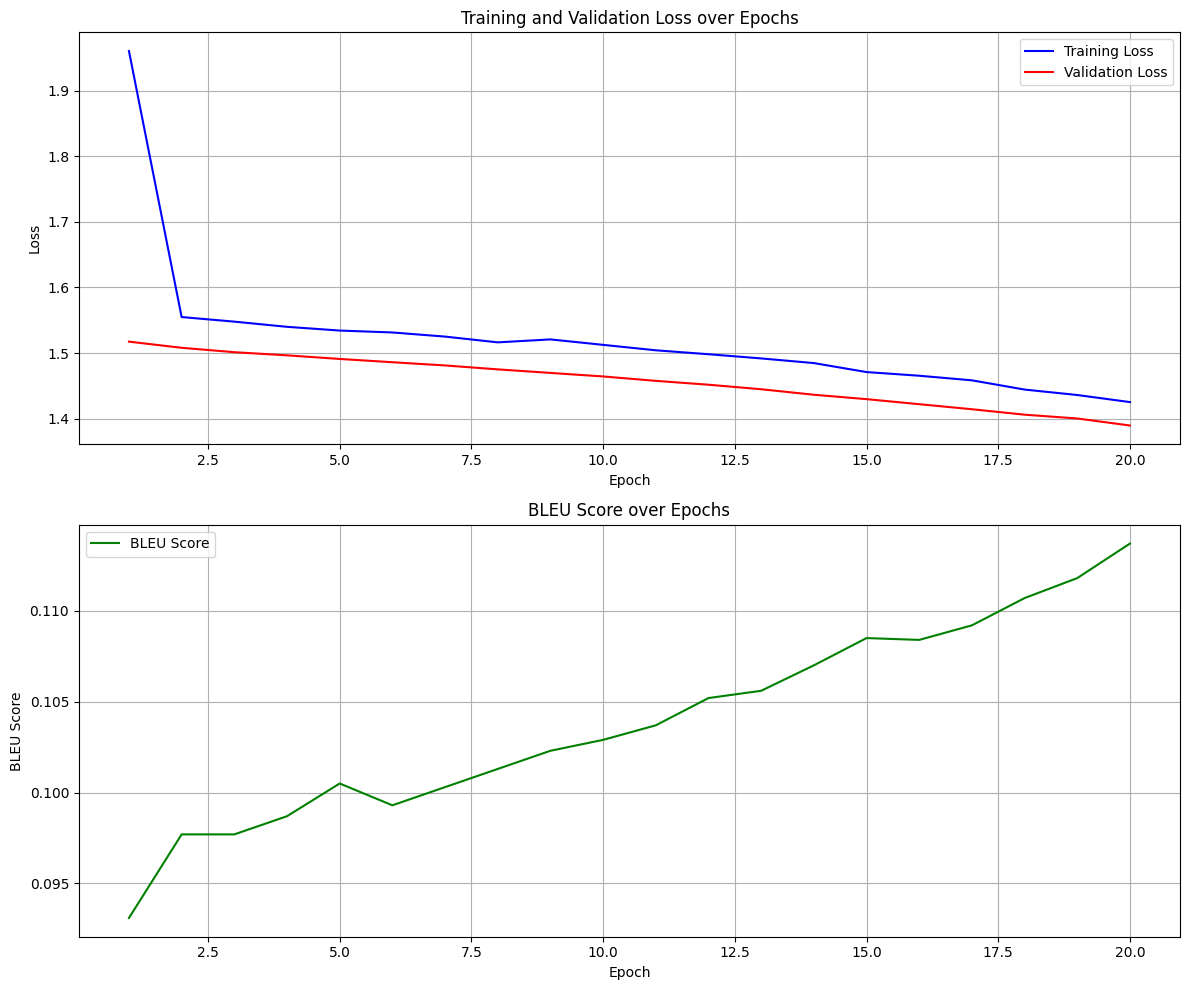

In [8]:
import re
import matplotlib.pyplot as plt
import numpy as np

def extract_metrics_from_log(log_text):
    """Extract metrics from training log text"""
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    bleu_scores = []
    epochs = []
    
    # Regular expressions to match metrics
    epoch_pattern = r"Epoch: (\d+), Train Loss: (\d+\.\d+)"
    val_pattern = r"Best Validation Loss: (\d+\.\d+)"
    bleu_pattern = r"Best BLEU Score: (\d+\.\d+)"
    
    # Split log into lines
    lines = log_text.split('\n')
    
    current_epoch = None
    for line in lines:
        # Extract epoch and training loss
        epoch_match = re.search(epoch_pattern, line)
        if epoch_match:
            current_epoch = int(epoch_match.group(1))
            epochs.append(current_epoch)
            train_losses.append(float(epoch_match.group(2)))
        
        # Extract validation loss
        val_match = re.search(val_pattern, line)
        if val_match:
            val_losses.append(float(val_match.group(1)))
            
        # Extract BLEU score
        bleu_match = re.search(bleu_pattern, line)
        if bleu_match:
            bleu_scores.append(float(bleu_match.group(1)))
    
    return epochs, train_losses, val_losses, bleu_scores

def plot_training_metrics(log_text):
    """Plot training metrics"""
    # Extract metrics
    epochs, train_losses, val_losses, bleu_scores = extract_metrics_from_log(log_text)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    # delete all duplicates in val_losses 
    #val_losses = list(dict.fromkeys(val_losses))
    # Plot losses
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss over Epochs')
    ax1.legend()
    ax1.grid(True)
    
    # Plot BLEU scores
    ax2.plot(epochs, bleu_scores, 'g-', label='BLEU Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('BLEU Score')
    ax2.set_title('BLEU Score over Epochs')
    ax2.legend()
    ax2.grid(True)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Print final metrics
    print(f"Final Metrics (Epoch {epochs[-1]}):")
    print(f"Training Loss: {train_losses[-1]:.4f}")
    print(f"Validation Loss: {val_losses[-1]:.4f}")
    print(f"BLEU Score: {bleu_scores[-1]:.4f}")
    
    # Calculate improvements
    loss_improvement = train_losses[0] - train_losses[-1]
    bleu_improvement = bleu_scores[-1] - bleu_scores[0]
    
    print("\nImprovements:")
    print(f"Training Loss decreased by: {loss_improvement:.4f}")
    print(f"BLEU Score increased by: {bleu_improvement:.4f}")
    
    plt.show()

# You can call the function with your log text
plot_training_metrics(text)